# Rigorous Thermodynamic Decomposition of Salt Effects on the Polymerization of Polyethylene Glycol
Stefan Hervø-Hansen<sup>a,*</sup>, Jan Heyda<sup>b,*</sup>, and Nobuyuki Matubayasi<sup>a,*</sup>.<br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup>b</sup> Department of Physical Chemistry, University of Chemistry and Technology, Prague CZ-16628, Czech Republic.<br>
<sup>*</sup> To whom correspondence may be addressed: stefan@cheng.es.osaka-u.ac.jp, heydaj@vscht.cz, and nobuyuki@cheng.es.osaka-u.ac.jp.

## Part 1: Simulations


### Introduction


### Methods & Materials
Molecular dynamics simulations are conducted using the openMM (7.7.0)[<sup>1</sup>](#fn1) software package modded with the parmed[<sup>2</sup>](#fn2) package and be found in the [Part 1 Jupyter notebook](Simulations.ipynb). For the simulation of PEG a CHARMM derived force field (C35r) was utilized, which has previously been able to reproduce hydrodynamic radii and shape anisotropy of PEG.[<sup>3</sup>](#fn3) The PEG force field was employed in combination with the SPC/E force field for water[<sup>4</sup>](#fn4) and optimized ion parameters for sodium thiocyanate and sodium chloride.[<sup>5,</sup>](#fn5)[<sup>6</sup>](#fn6)
The isothermal-isobaric ensemble will be sampled using a combination of a "Middle" discretization Langevin leap-frog integrator[<sup>7</sup>](#fn7) and a Monte Carlo barostat[<sup>8,</sup>](#fn8)[<sup>9</sup>](#fn9). The trajectories was analyzed using MDtraj[<sup>10</sup>](#fn10) for structural properties, while ERmod[<sup>11</sup>](#fn11) be utilized for the calculation of solvation free energies and can be found in the [Part 2 Jupyter notebook](Analysis.ipynb).

### References
1. <span id="fn1"> P. Eastman, et al., OpenMM 7: Rapid development of high performance algorithms for molecular dynamics. PLoS Comput Biol 13, e1005659 (2017).</span><br>
2. <span id="fn2"> https://github.com/ParmEd/ParmEd </span><br>
3. <span id="fn3"> H. Lee, R. M. Venable, A. D. MacKerell Jr., R. W. Pastor, Molecular Dynamics Studies of Polyethylene Oxide and Polyethylene Glycol: Hydrodynamic Radius and Shape Anisotropy. Biophysical Journal 95, 1590–1599 (2008). </span><br>
4. <span id="fn4"> H. J. C. Berendsen, J. R. Grigera, T. P. Straatsma, The missing term in effective pair potentials. J. Phys. Chem. 91, 6269–6271 (1987). </span><br>
5. <span id="fn5"> T. Křížek, et al., Electrophoretic mobilities of neutral analytes and electroosmotic flow markers in aqueous solutions of Hofmeister salts. ELECTROPHORESIS 35, 617–624 (2014). </span><br>
6. <span id="fn6"> J. Heyda, J. C. Vincent, D. J. Tobias, J. Dzubiella, P. Jungwirth, Ion Specificity at the Peptide Bond: Molecular Dynamics Simulations of N-Methylacetamide in Aqueous Salt Solutions. J. Phys. Chem. B 114, 1213–1220 (2009). </span><br>
7. <span id="fn7"> Z. Zhang, X. Liu, K. Yan, M. E. Tuckerman, J. Liu, Unified Efficient Thermostat Scheme for the Canonical Ensemble with Holonomic or Isokinetic Constraints via Molecular Dynamics. J. Phys. Chem. A 123, 6056–6079 (2019). </span><br>
8. <span id="fn8"> K.-H. Chow, D. M. Ferguson, Isothermal-isobaric molecular dynamics simulations with Monte Carlo volume sampling. Computer Physics Communications 91, 283–289 (1995). </span><br>
9. <span id="fn9"> J. Åqvist, P. Wennerström, M. Nervall, S. Bjelic, B. O. Brandsdal, Molecular dynamics simulations of water and biomolecules with a Monte Carlo constant pressure algorithm. Chemical Physics Letters 384, 288–294 (2004). </span><br>
10. <span id="fn10"> R. T. McGibbon, et al., MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. Biophysical Journal 109, 1528–1532 (2015) </span><br>
11. <span id="fn11"> S. Sakuraba, N. Matubayasi, Ermod: Fast and versatile computation software for solvation free energy with approximate theory of solutions. J. Comput. Chem. 35, 1592–1608 (2014). </span><br>


## Import of Python Modules & Auxiliary Functions

In [1]:
# Notebook dependent libs
import parmed as pmd
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import os, re, time
from shutil import copyfile
import pandas as pd
from scipy import stats
from distutils.spawn import find_executable
from IPython.display import IFrame

# Simulation specific libs
import sys
from openmm import app
import openmm as mm
import openmmtools as mmtools
import parmed as pmd
import Auxiliary.Modded_Simulations as mmmod
import mdtraj as md

# Check for external programs
if None in [find_executable('packmol'), find_executable('perl')]:
    print('WARNING: External program missing!')
    

homedir = !pwd
homedir = homedir[0]
print(homedir)

/work/1/ERCINCR/stefan/PEO-Solubility


## Molecular Dynamics Simulations

Write about simulation strategy.

### Simulation settings
For the calculation of solvation free energies, we need to simulate the solvated state ($\lambda=1$) and the reference state ($\lambda=0$), with the duration of the simulation determined by together with the output frequency for the saving configurations and other thermodynamic properties for statistical evaluation, all of which is determined by the `states` variable. The molecular dynamics simulations have been set up such that one can run `Nruns` independent molecular dynamics simulations. The system composition of salts and their concentrations are controlled by the variables `salts` and `concentrations` respectively.

In order to include the effect of flexibility of the solute, we additionally need to generate an ensemble of the solute in a vacuum. In order to do so, the variable `GENERATE_SOLUTE` has been introduced and must be set to True. The vacuum simulations are generated from the `No_salt` entry input files in the `salts` variable and are therefore <i>required</i> before the vacuum inputs can be generated. The structural ensemble is constructed in the canonical ($NVT$) ensemble using molecular dynamics in which the forces and energies are evaluated without cutoffs.

In [24]:
# State of simulations, (outFreq is steps per frame)
states = {
          'conf':{'Nsteps': 50000000, 'OutFreq': 2500}, # 200 nanoseconds, 20000 frames
          'sol': {'Nsteps': 50000000, 'OutFreq': 1000}, # 200 nanoseconds, 50000 frames
          'ref': {'Nsteps': 12500000, 'OutFreq': 2500}, # 50 nanoseconds,   5000 frames
         }

nmers = [2, 4, 6, 8, 15, 36]
NConfs = 50

salts = {
         'No_salt': {'Cation': 'No_', 'Anion': 'salt' },
#         'NaCl'   : {'Cation': 'Na' , 'Anion': 'Cl'   },
#         'CsCl'   : {'Cation': 'Cs' , 'Anion': 'Cl'   },
#         'NaSCN'  : {'Cation': 'Na' , 'Anion': 'SCN'  },
#         'CsSCN'  : {'Cation': 'Cs' , 'Anion': 'SCN'  },
        }

# Approximate concentrations of salts with
concentrations = {
#                  0.00: {'PEG': 1, 'Water': 10000, 'Cation': 0,   'Anion': 0},
                  1.00: {'PEG': 1, 'Water': 10000, 'Cation': 109, 'Anion': 109},
#                  2.00: {'PEG': 1, 'Water': 10000, 'Cation': 218, 'Anion': 218},
                 }

#* Calculated by hand *#
# Cube length ≈ 66.95 Ångstroms. Round up to 70 Å and then adjust to correct volume with barostat.

### Step 1. Generation of Solute Configurations

#### Molecular dynamics setup using OpenMM

In [ ]:
%cd -q $homedir

GENERATE_SOLUTE = False     

openmm_script="""# Imports
import sys
import os
import openmm as mm
from openmm import app
from openmm import unit as u
from mdtraj.reporters import XTCReporter

print('Loading initial configuration and toplogy')
pdb = app.PDBFile('PEG_{nmer}.pdb')
forcefield = app.ForceField('{homedir}/Force_fields/peg.xml',
                            '{homedir}/Force_fields/spce.xml',
                            '{homedir}/Force_fields/SCN.xml',
                            '{homedir}/Force_fields/ions.xml')
                         
modeller = app.Modeller(pdb.topology, pdb.positions)
modeller.addHydrogens(forcefield, pH=7.0)
modeller.addSolvent(forcefield, model='spce', numAdded=10000, neutralize=False)

app.PDBFile.writeFile(modeller.topology, modeller.positions, open('PEG_{nmer}_hydrated.pdb', 'w'))

# Creating system
print('Creating OpenMM System')
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME, ewaldErrorTolerance=0.0005, switchDistance=1*u.nanometer,
                                 nonbondedCutoff=1.2*u.nanometers, constraints=app.HBonds, rigidWater=True, hydrogenMass=1.25*u.dalton)

# Calculating total mass of system
total_mass = u.sum([system.getParticleMass(i) for i in range(system.getNumParticles())])
        
# Temperature-coupling by leap frog (BAOAB) Langevin integrator (NVT)
integrator = mm.LangevinMiddleIntegrator(298.15*u.kelvin, 1.0/u.picoseconds, 4.0*u.femtoseconds)

# Pressure-coupling by a Monte Carlo Barostat (NPT)
system.addForce(mm.MonteCarloBarostat(1*u.bar, 298.15*u.kelvin, 25))

platform = mm.Platform.getPlatformByName('CUDA')
properties = {{'CudaPrecision': 'mixed', 'CudaDeviceIndex': '0,1,2,3'}}

# Create the Simulation object
sim = app.Simulation(modeller.topology, system, integrator, platform, properties)

# Set the particle positions
sim.context.setPositions(modeller.positions)

# Minimize the energy
print('Minimizing energy')
sim.minimizeEnergy(tolerance=1*u.kilojoule/u.mole, maxIterations=1000000)
    
# Draw initial MB velocities
sim.context.setVelocitiesToTemperature(298.15*u.kelvin)

# Equlibrate simulation
print('Equilibrating...')
sim.step(250000)  # 250000*4 fs = 1.0 ns

# Set up the reporters
sim.reporters.append(app.StateDataReporter('output.dat', {outFreq}, totalSteps={Nsteps}+250000,
    time=True, potentialEnergy=True, kineticEnergy=True, temperature=True, volume=True, density=True,
    systemMass=total_mass, remainingTime=True, speed=True, separator='\t'))

# Set up trajectory reporter
sim.reporters.append(XTCReporter('trajectory_{state}.xtc', reportInterval={outFreq}, append=False))

# Run dynamics
print('Running dynamics! (NPT)')
sim.step({Nsteps})
"""           

N_simulations = 0
if GENERATE_SOLUTE:
    for nmer in nmers:
        %cd -q $homedir/Simulations/$nmerdir/Solute
        
        with open('openMM_{state}.py'.format(state=state), 'w') as text_file:
            text_file.write(openmm_script.format(Nsteps=settings['Nsteps'], outFreq=settings['OutFreq'],
                                                 nmer=nmer, homedir=homedir))
        print('Wrote run_openMM.py files to '+os.getcwd())

print('Simulations about to be submitted: {}'.format(N_simulations))

#### Submit script

In [ ]:
%cd -q $homedir

submit_script="""#!/bin/bash
#PBS -A ERCINCR
#PBS -q gen_S
#PBS -b 1
#PBS -N PEG-{nmer}_Solute             # Name of job
#PBS -e run.err               # error output
#PBS -o run.out               # output file name

source ~/.bashrc
source ~/.bash_profile

cd {path}

python openMM.py"""

if GENERATE_SOLUTE:
    for nmer in nmers:
        %cd -q $homedir/Simulations/$nmerdir/Solute
        with open('submit.pbs', 'w') as text_file:
            text_file.write(submit_script.format(nmer=nmer, path=os.getcwd()))
        !qsub submit.pbs
        time.sleep(1) # Safety in submission of jobs: can cause problems if too fast

#### Post simulation trajectory processing

In [ ]:
%cd -q $homedir

if GENERATE_SOLUTE:
    for nmer in nmers:
        pdb = md.load_pdb('Simulations/PEG{nmer}mer/Solute/PEG_{nmer}_hydrated.pdb'.format(nmer=nmer))
        PEG_indices = pdb.topology.select('(resname PGH) or (resname PGM) or (resname PGT)')
        traj = md.load_xtc('Simulations/PEG{}mer/Solute/trajectory.xtc'.format(nmer),
                           top='PDB_files/PEO-{}-mer.pdb'.format(nmer), atom_indices=PEG_indices)
        traj.save_xtc('Simulations/PEG{}mer/Solute/trajectory_dry.xtc'.format(nmer), force_overwrite=True)

#### State reporter inspection

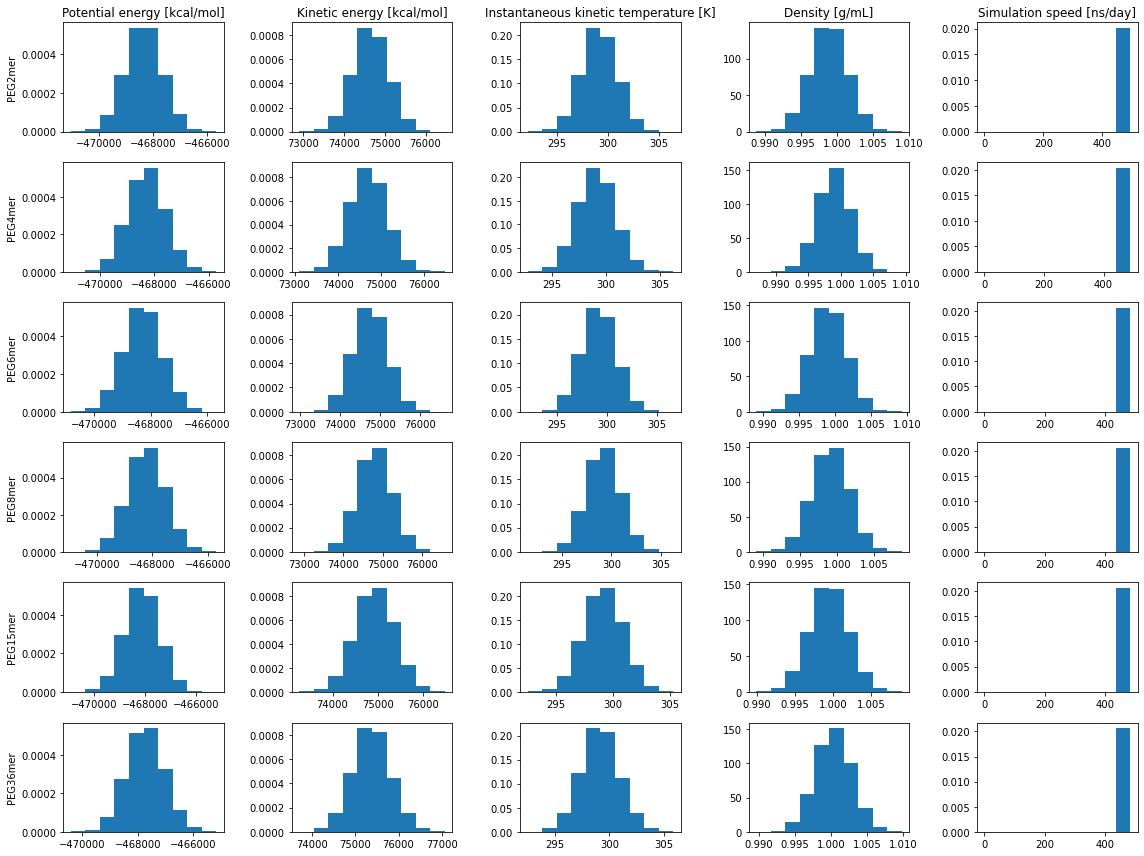

In [5]:
%cd -q $homedir

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16,12))

index = 0

for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    %cd -q $homedir/Simulations/$nmerdir/Solute
    data = np.loadtxt('output.dat', skiprows=1, usecols=(1,2,3,5,6))
            
    for i, observable in enumerate(data.T):
        axes[index,i].hist(observable, density=True)
        
    axes[index, 0].set_ylabel('PEG{}mer'.format(nmer))
    
    index+=1
    
axes[0, 0].set_title('Potential energy [kcal/mol]')
axes[0, 1].set_title('Kinetic energy [kcal/mol]')
axes[0, 2].set_title('Instantaneous kinetic temperature [K]')
axes[0, 3].set_title('Density [g/mL]')
axes[0, 4].set_title('Simulation speed [ns/day]')

fig.tight_layout()

### Step 2. Generation of Solvent Configurations at Constant Solute Configuration
#### Construction of topology and structure files

In [ ]:
%cd -q $homedir

packmol_script="""
tolerance 2.0
filetype pdb
output PEG_{nmer}_{cation}{anion}_sol.pdb

add_box_sides 1.0

structure PEG_structure.pdb
        number {N_PEG}
        fixed 25. 25. 25. 0. 0. 0.
        centerofmass
end structure

{salt}structure {homedir}/PDB_files/{anion}.pdb
{salt}        number {N_anion}
{salt}        inside cube 0. 0. 0. 70.
{salt}end structure

{salt}structure {homedir}/PDB_files/{cation}.pdb
{salt}        number {N_cation}
{salt}        inside cube 0. 0. 0. 70.
{salt}end structure
"""

traj_indices = np.rint(np.linspace(0, states['conf']['Nsteps']//states['conf']['OutFreq'], NConfs)).astype(np.int64)

for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    peg_traj = md.load_xtc(filename='{}/Simulations/{}/Solute/trajectory_dry.xtc'.format(homedir, nmerdir),
                           top='{}/PDB_files/PEO-{}-mer.pdb'.format(homedir, nmer))
    
    for saltdir, salt in salts.items():
        for conc, Nparticles in concentrations.items():
            concdir = '{0:.2f}'.format(conc)
            for conf in range(NConfs):
                if conc == 0 and saltdir == 'No_salt':
                    %cd -q $homedir/Simulations/$nmerdir/$saltdir/$conf
                elif conc != 0 and saltdir == 'No_salt':
                    continue
                else:
                    %cd -q $homedir/Simulations/$nmerdir/$saltdir/$concdir/$conf
                
                # Save PEG conformation
                peg_traj[traj_indices[conf]].save_pdb('PEG_structure.pdb', force_overwrite=True)
                
                # Packmol Input
                with open('packmol.in', 'w') as text_file:
                    # Fix for no salt
                    if conc == 0:
                        saltFix='#'
                    else:
                        saltFix=''
                    text_file.write(packmol_script.format(N_PEG=Nparticles['PEG'], nmer=nmer, salt=saltFix,
                                                          N_cation=Nparticles['Cation'], N_anion=Nparticles['Anion'],
                                                          cation=salt['Cation'], anion=salt['Anion'],
                                                          homedir=homedir))
                !packmol < packmol.in
                
                # Collect it all for λ=1:
                pdb = app.PDBFile('PEG_{nmer}_{salt}_sol.pdb'.format(nmer=nmer, salt=saltdir))
                forcefield = app.ForceField(homedir+'/Force_fields/peg.xml', homedir+'/Force_fields/spce.xml',
                                            homedir+'/Force_fields/SCN.xml', homedir+'/Force_fields/ions.xml')
        
                modeller = app.Modeller(pdb.topology, pdb.positions)
                modeller.addHydrogens(forcefield, pH=7.0)
                modeller.addSolvent(forcefield, model='spce', numAdded=Nparticles['Water'], neutralize=False)
                system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME, ewaldErrorTolerance=0.0005,
                                                 nonbondedCutoff=1.2*pmd.unit.nanometers, rigidWater=False)
                mol = pmd.openmm.load_topology(modeller.topology, system, modeller.positions)
                mol.save('PEG_{nmer}_{salt}_hydrated_sol.pdb'.format(nmer=nmer, salt=saltdir), overwrite=True)
                if conf == 0:
                    mol.save('../PEG_{nmer}_{salt}_hydrated_sol.parm7'.format(nmer=nmer, salt=saltdir), overwrite=True)
                
                # Generate files for λ=0:
                if saltdir == 'No_salt': # This option for monatomic ions or water alone
                    mol.strip(':PGH,:PGM,:PGT')
                    mol.save('PEG_{nmer}_{salt}_ref.pdb'.format(nmer=nmer, salt=saltdir), overwrite=True)
                else:                    # This option for multiatomic ions
                    mol = md.load_pdb('PEG_{nmer}_{salt}_sol.pdb'.format(nmer=nmer, salt=saltdir))
                    solvent = mol.topology.select('not (resname PGH or resname PGM or resname PGT)')
                    mol.atom_slice(solvent, inplace=True)
                    mol.save('PEG_{nmer}_{salt}_ref.pdb'.format(nmer=nmer, salt=saltdir), force_overwrite=True)
                    
                print('Wrote initial configurations and topology files to'+os.getcwd())

#### Construction of molecular dynamics input for OpenMM

In [ ]:
# openMM script for solution and reference simulations
openmm_script="""# Imports
import sys
import os
import openmm as mm
from openmm import app
from openmm import unit as u
from mdtraj.reporters import XTCReporter

print('Loading initial configuration and toplogy')
pdb = app.PDBFile('PEG_{nmer}_{salt}_{state}.pdb')
forcefield = app.ForceField('{homedir}/Force_fields/peg.xml',
                            '{homedir}/Force_fields/spce.xml',
                            '{homedir}/Force_fields/SCN.xml',
                            '{homedir}/Force_fields/ions.xml')

IS_SOLVATED = False
for residue in pdb.topology.residues():
    if residue.name == 'HOH':
        IS_SOLVATED = True
        break

if IS_SOLVATED == False:                         
    modeller = app.Modeller(pdb.topology, pdb.positions)
    modeller.addHydrogens(forcefield, pH=7.0)
    modeller.addSolvent(forcefield, model='spce', numAdded=10000, neutralize=False)
else:
    modeller = pdb

# Creating system
print('Creating OpenMM System')
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME, ewaldErrorTolerance=0.0005, switchDistance=1*u.nanometer,
                                 nonbondedCutoff=1.2*u.nanometers, constraints=app.HBonds, rigidWater=True, hydrogenMass=1.25*u.dalton)

# Calculating total mass of system
total_mass = u.sum([system.getParticleMass(i) for i in range(system.getNumParticles())])
        
# Temperature-coupling by leap frog (BAOAB) Langevin integrator (NVT)
integrator = mm.LangevinMiddleIntegrator(298.15*u.kelvin, 1.0/u.picoseconds, 4.0*u.femtoseconds)

# Pressure-coupling by a Monte Carlo Barostat (NPT)
system.addForce(mm.MonteCarloBarostat(1*u.bar, 298.15*u.kelvin, 25))

platform = mm.Platform.getPlatformByName('CUDA')
properties = {{'CudaPrecision': 'mixed', 'CudaDeviceIndex': '0,1,2,3'}}

# Create the Simulation object
sim = app.Simulation(modeller.topology, system, integrator, platform, properties)

# Set the particle positions
sim.context.setPositions(modeller.positions)

# Minimize the energy
print('Minimizing energy')
sim.minimizeEnergy(tolerance=1*u.kilojoule/u.mole, maxIterations=1000000)
    
# Draw initial MB velocities
sim.context.setVelocitiesToTemperature(298.15*u.kelvin)

# Equlibrate simulation
print('Equilibrating...')
sim.step(250000)  # 250000*4 fs = 1.0 ns

# Set up the reporters
sim.reporters.append(app.StateDataReporter('output_{state}.dat', {outFreq}, totalSteps={Nsteps}+250000,
    time=True, potentialEnergy=True, kineticEnergy=True, temperature=True, volume=True, density=True,
    systemMass=total_mass, remainingTime=True, speed=True, separator='\t'))

# Set up trajectory reporter
sim.reporters.append(XTCReporter('trajectory_{state}.xtc', reportInterval={outFreq}, append=False))

# Run dynamics
print('Running dynamics! (NPT)')
sim.step({Nsteps})

# Print PME information
print('''
PARTICLE MESH EWALD PARAMETERS
Separation parameter: {{}}
Number of grid points along the X axis: {{}}
Number of grid points along the Y axis: {{}}
Number of grid points along the Z axis: {{}}
'''.format(*sim.system.getForces()[3].getPMEParametersInContext(sim.context)))

In [ ]:
%cd -q $homedir
N_simulations = 0
for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for saltdir, salt in salts.items():
        for conc in concentrations:
            concdir = '{0:.2f}'.format(conc)
            for conf in range(NConfs):
                if conc == 0 and saltdir == 'No_salt':
                    %cd -q $homedir/Simulations/$nmerdir/$saltdir/$conf
                elif conc != 0 and saltdir == 'No_salt':
                    continue
                else:
                    %cd -q $homedir/Simulations/$nmerdir/$saltdir/$concdir/$conf
                    
                for state, settings in states.items():
                    if state == 'conf':
                        continue
                    with open('openMM_{state}.py'.format(state=state), 'w') as text_file:
                        text_file.write(openmm_script.format(state=state, Nsteps=settings['Nsteps'], homedir=homedir,
                                                             outFreq=settings['OutFreq'], salt=saltdir, nmer=nmer)
                    N_simulations+=1
                print('Wrote run_openMM.py files to '+os.getcwd())

print('Simulations about to be submitted: {}'.format(N_simulations))

#### Submit script

In [ ]:
submit_script="""#!/bin/bash
#PBS -A ERCINCR
#PBS -q gen_S
#PBS -b 1
#PBS -N PEG-{nmer}_{conc}_M_{salt}_{state}  # Name of job
#PBS -e run_{state}.err           # Error output
#PBS -o run_{state}.out           # Output file name

source ~/.bashrc
source ~/.bash_profile

cd {path}

python openMM_{state}.py"""

for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for saltdir in salts:
        for conc in concentrations:
            concdir = '{0:.2f}'.format(conc)
            for conf in range(NConfs):
                if conc == 0 and saltdir == 'No_salt':
                    %cd -q $homedir/Simulations/$nmerdir/$saltdir/$conf
                elif conc != 0 and saltdir == 'No_salt':
                    continue
                else:
                    %cd -q $homedir/Simulations/$nmerdir/$saltdir/$concdir/$conf
                for state in states:
                    if state == 'conf':
                        continue
                    with open('submit_{state}.pbs'.format(state=state), 'w') as text_file:
                        text_file.write(submit_script.format(conc=conc, state=state, nmer=nmer,
                                                         path=os.getcwd(), salt=saltdir))
                !qsub submit_sol.pbs
                time.sleep(1) # Safety in submission of jobs: can cause problems if too fast
                !qsub submit_ref.pbs
                time.sleep(1) # Safety in submission of jobs: can cause problems if too fast

### Construction of topology (.top) and structure (.pdb) files
Fully automated construction of topologies files in gromacs format and initial configurations using packmol. No major important parameters to edit in the following code.

In [ ]:
packmol_script="""
tolerance 2.0
filetype pdb
output PEG_{nmer}_{cation}{anion}_sol.pdb

add_box_sides 1.0

structure {homedir}/PDB_files/PEO-{nmer}-mer.pdb
        number {N_PEG}
        fixed 25. 25. 25. 0. 0. 0.
        centerofmass
end structure

{salt}structure {homedir}/PDB_files/{anion}.pdb
{salt}        number {N_anion}
{salt}        inside cube 0. 0. 0. 70.
{salt}end structure

{salt}structure {homedir}/PDB_files/{cation}.pdb
{salt}        number {N_cation}
{salt}        inside cube 0. 0. 0. 70.
{salt}end structure
"""

In [ ]:
%cd -q $homedir
for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for saltdir, salt in salts.items():
        for conc, Nparticles in concentrations.items():
            concdir = '{0:.2f}'.format(conc)
            if conc == 0 and saltdir == 'No_salt':
                %cd -q $homedir/Simulations/$nmerdir/$saltdir
            elif conc != 0 and saltdir == 'No_salt':
                continue
            else:
                %cd -q $homedir/Simulations/$nmerdir/$saltdir/$concdir
                
            # Packmol Input
            with open('packmol.in', 'w') as text_file:
                # Fix for no salt
                if conc == 0:
                    saltFix='#'
                else:
                    saltFix=''
                text_file.write(packmol_script.format(N_PEG=Nparticles['PEG'], nmer=nmer, salt=saltFix,
                                                      N_cation=Nparticles['Cation'], N_anion=Nparticles['Anion'],
                                                      cation=salt['Cation'], anion=salt['Anion'],
                                                      homedir=homedir))
            !packmol < packmol.in
            
            # Collect it all for λ=1:
            pdb = app.PDBFile('PEG_{nmer}_{salt}_sol.pdb'.format(nmer=nmer, salt=saltdir))
            forcefield = app.ForceField(homedir+'/Force_fields/peg.xml', homedir+'/Force_fields/spce.xml',
                                        homedir+'/Force_fields/SCN.xml', homedir+'/Force_fields/ions.xml')
    
            modeller = app.Modeller(pdb.topology, pdb.positions)
            modeller.addHydrogens(forcefield, pH=7.0)
            modeller.addSolvent(forcefield, model='spce', numAdded=Nparticles['Water'], neutralize=False)
            system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME, ewaldErrorTolerance=0.0005,
                                             nonbondedCutoff=1.2*pmd.unit.nanometers, rigidWater=False)
            mol = pmd.openmm.load_topology(modeller.topology, system, modeller.positions)
            mol.save('PEG_{nmer}_{salt}_hydrated_sol.pdb'.format(nmer=nmer, salt=saltdir), overwrite=True)
            mol.save('PEG_{nmer}_{salt}_hydrated_sol.parm7'.format(nmer=nmer, salt=saltdir), overwrite=True)
            
            # Generate files for λ=0:
            if saltdir == 'No_salt': # This option for monatomic ions or water alone
                mol.strip(':PGH,:PGM,:PGT')
                mol.save('PEG_{nmer}_{salt}_ref.pdb'.format(nmer=nmer, salt=saltdir), overwrite=True)
            else:                    # This option for multiatomic ions
                mol = md.load_pdb('PEG_{nmer}_{salt}_sol.pdb'.format(nmer=nmer, salt=saltdir))
                solvent = mol.topology.select('not (resname PGH or resname PGM or resname PGT)')
                mol.atom_slice(solvent, inplace=True)
                mol.save('PEG_{nmer}_{salt}_ref.pdb'.format(nmer=nmer, salt=saltdir), force_overwrite=True)
                
            print('Wrote initial configurations and topology files to'+os.getcwd())

### Simulation setup using OpenMM
Fully automated construction of simulation input files using python API for OpenMM. In the following one can edit the integration scheme and its parameters set in the variable `integrator` as well as editing the barostat as currently determined from `mm.MonteCarloBarostat`. Additionally one may change the non-bonded methods and their cutoffs in the `system` variable with the option of adding Lennard-Jones switching functions via the `forces` variable. Finally one may edit the number of minimization (`sim.minimizeEnergy`) and equilibration steps conducted as well as choosing whether the simulation should be conducted on GPUs or CPUs via the `platform` and `properties` variables.

In [ ]:
# openMM script for solution and reference simulations
openmm_script="""# Imports
import sys
import os
import openmm as mm
from openmm import app
from openmm import unit as u
from mdtraj.reporters import XTCReporter

DO_SIMULATED_TEMPERING = {DO_ST}

print('Loading initial configuration and toplogy')
pdb = app.PDBFile('PEG_{nmer}_{salt}_{state}.pdb')
forcefield = app.ForceField('{homedir}/Force_fields/peg.xml',
                            '{homedir}/Force_fields/spce.xml',
                            '{homedir}/Force_fields/SCN.xml',
                            '{homedir}/Force_fields/ions.xml')

IS_SOLVATED = False
for residue in pdb.topology.residues():
    if residue.name == 'HOH':
        IS_SOLVATED = True
        break

if IS_SOLVATED == False:                         
    modeller = app.Modeller(pdb.topology, pdb.positions)
    modeller.addHydrogens(forcefield, pH=7.0)
    modeller.addSolvent(forcefield, model='spce', numAdded=10000, neutralize=False)
else:
    modeller = pdb

# Creating system
print('Creating OpenMM System')
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME, ewaldErrorTolerance=0.0005, switchDistance=1*u.nanometer,
                                 nonbondedCutoff=1.2*u.nanometers, constraints=app.HBonds, rigidWater=True, hydrogenMass=1.25*u.dalton)

# Calculating total mass of system
total_mass = u.sum([system.getParticleMass(i) for i in range(system.getNumParticles())])
        
# Temperature-coupling by leap frog (BAOAB) Langevin integrator (NVT)
integrator = mm.LangevinMiddleIntegrator(298.15*u.kelvin, 1.0/u.picoseconds, 4.0*u.femtoseconds)

# Pressure-coupling by a Monte Carlo Barostat (NPT)
system.addForce(mm.MonteCarloBarostat(1*u.bar, 298.15*u.kelvin, 25))

platform = mm.Platform.getPlatformByName('CUDA')
properties = {{'CudaPrecision': 'mixed', 'CudaDeviceIndex': '0,1,2,3'}}

# Create the Simulation object
sim = app.Simulation(modeller.topology, system, integrator, platform, properties)

# Set the particle positions
sim.context.setPositions(modeller.positions)

# Minimize the energy
print('Minimizing energy')
sim.minimizeEnergy(tolerance=1*u.kilojoule/u.mole, maxIterations=1000000)
    
# Draw initial MB velocities
sim.context.setVelocitiesToTemperature(298.15*u.kelvin)

# Equlibrate simulation
print('Equilibrating...')
sim.step(250000)  # 250000*4 fs = 1.0 ns

# Set up the reporters
sim.reporters.append(app.StateDataReporter('output_{state}.dat', {outFreq}, totalSteps={Nsteps}+250000,
    time=True, potentialEnergy=True, kineticEnergy=True, temperature=True, volume=True, density=True,
    systemMass=total_mass, remainingTime=True, speed=True, separator='\t'))

# Set up trajectory reporter
sim.reporters.append(XTCReporter('trajectory_{state}.xtc', reportInterval={outFreq}, append=False))

if DO_SIMULATED_TEMPERING:
    sim = app.SimulatedTempering(sim, numTemperatures={numT}, minTemperature={minT}, maxTemperature={maxT},
                                 tempChangeInterval=25, reportInterval={outT}, reportFile='{fileT}')

# Run dynamics
print('Running dynamics! (NPT)')
sim.step({Nsteps})

# Print PME information
try:
    print('''
PARTICLE MESH EWALD PARAMETERS
Separation parameter: {{}}
Number of grid points along the X axis: {{}}
Number of grid points along the Y axis: {{}}
Number of grid points along the Z axis: {{}}
'''.format(*sim.system.getForces()[3].getPMEParametersInContext(sim.context)))
except:
    print('''
PARTICLE MESH EWALD PARAMETERS (Simulated tempering)
Separation parameter: {{}}
Number of grid points along the X axis: {{}}
Number of grid points along the Y axis: {{}}
Number of grid points along the Z axis: {{}}
'''.format(*sim.system.getForces()[3].getPMEParametersInContext(sim.simulation.context)))
"""

In [ ]:
%cd -q $homedir
N_simulations = 0
for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for saltdir, salt in salts.items():
        for conc in concentrations:
            concdir = '{0:.2f}'.format(conc)
            if conc == 0 and saltdir == 'No_salt':
                %cd -q $homedir/Simulations/$nmerdir/$saltdir
            elif conc != 0 and saltdir == 'No_salt':
                continue
            else:
                %cd -q $homedir/Simulations/$nmerdir/$saltdir/$concdir
            for state, settings in states.items():
                
                with open('openMM_{state}.py'.format(state=state), 'w') as text_file:
                    text_file.write(openmm_script.format(state=state, Nsteps=settings['Nsteps'], homedir=homedir,
                                                         outFreq=settings['OutFreq'], salt=saltdir, nmer=nmer,
                                                         minT=ST_settings['minTemperature'], maxT=ST_settings['maxTemperature'],
                                                         numT=ST_settings['numTemperatures'], outT=ST_settings['reportInterval'],
                                                         fileT=ST_settings['reportFile'], DO_ST=settings['DO_SIMULATED_TEMPERING']))
                N_simulations+=1
            print('Wrote run_openMM.py files to '+os.getcwd())
    if GENERATE_SOLUTE:
        %cd -q $homedir/Simulations/$nmerdir/Solute
        with open('openMM.py', 'w') as text_file:
            text_file.write(openmm_vacuum_script.format(Nsteps=10000000, nmer=nmer, outFreq=1000))
            N_simulations+=1
            print('Wrote run_openMM.py files to '+os.getcwd())

print('Simulations about to be submitted: {}'.format(N_simulations))

### Submit script
Submit script for servers employing job scheduling. The below example is utilizing PBS (for a quick guide see [here](https://latisresearch.umn.edu/creating-a-PBS-script)). However the code below may be edited to utilize Slurm instead (documentation [here](https://slurm.schedmd.com)) by changing the variable `submit_script` and by executing the commands `!sbatch submit_sol.pbs` and `!sbatch submit_ref.pbs` instead of `qsub`.

In [ ]:
submit_script="""#!/bin/bash
#PBS -A ERCINCR
#PBS -q gen_S
#PBS -b 1
#PBS -N PEG-{nmer}_{conc}_M_{salt}_{state}  # Name of job
#PBS -e run_{state}.err           # Error output
#PBS -o run_{state}.out           # Output file name

source ~/.bashrc
source ~/.bash_profile

cd {path}

python openMM_{state}.py"""

submit_vacuum_script="""#!/bin/bash
#PBS -A ERCINCR
#PBS -q gen_S
#PBS -b 1
#PBS -N PEG-{nmer}_Solute             # Name of job
#PBS -e run.err               # error output
#PBS -o run.out               # output file name

source ~/.bashrc
source ~/.bash_profile

cd {path}

python openMM.py"""

In [ ]:
for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for saltdir in salts:
        for conc in concentrations:
            concdir = '{0:.2f}'.format(conc)
            if conc == 0 and saltdir == 'No_salt':
                %cd -q $homedir/Simulations/$nmerdir/$saltdir
            elif conc != 0 and saltdir == 'No_salt':
                continue
            else:
                %cd -q $homedir/Simulations/$nmerdir/$saltdir/$concdir
            for state in states:
                with open('submit_{state}.pbs'.format(state=state), 'w') as text_file:
                    text_file.write(submit_script.format(conc=conc, state=state, nmer=nmer,
                                                     path=os.getcwd(), salt=saltdir))
            !qsub submit_sol.pbs
            time.sleep(1) # Safety in submission of jobs: can cause problems if too fast
            !qsub submit_ref.pbs
            time.sleep(1) # Safety in submission of jobs: can cause problems if too fast
            
    if GENERATE_SOLUTE:
        %cd -q $homedir/Simulations/$nmerdir/Solute
        with open('submit.pbs', 'w') as text_file:
            text_file.write(submit_vacuum_script.format(nmer=nmer, path=os.getcwd()))
        !qsub submit.pbs
        time.sleep(1) # Safety in submission of jobs: can cause problems if too fast

## State Reporter Inspection
### Reference state

In [ ]:
%cd -q $homedir

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16,12))

index = 0

for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for saltdir in salts:
        for conc in concentrations:
            concdir = '{0:.2f}'.format(conc)
            if conc == 0 and saltdir == 'No_salt':
                %cd -q $homedir/Simulations/$nmerdir/$saltdir
            elif conc != 0 and saltdir == 'No_salt':
                continue
            else:
                %cd -q $homedir/Simulations/$nmerdir/$saltdir/$concdir

            data = np.loadtxt('output_ref.dat', skiprows=1, usecols=(1,2,3,5,6))
            
            for i, observable in enumerate(data.T):
                axes[index,i].hist(observable, density=True)
                
            axes[index, 0].set_ylabel('PEG{}mer'.format(nmer))
            
            index+=1
            
axes[0, 0].set_title('Potential energy [kcal/mol]')
axes[0, 1].set_title('Kinetic energy [kcal/mol]')
axes[0, 2].set_title('Instantaneous kinetic temperature [K]')
axes[0, 3].set_title('Density [g/mL]')
axes[0, 4].set_title('Simulation speed [ns/day]')

fig.tight_layout()

### Solution state

In [ ]:
%cd -q $homedir

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16,12))

index = 0

for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for saltdir in salts:
        for conc in concentrations:
            concdir = '{0:.2f}'.format(conc)
            if conc == 0 and saltdir == 'No_salt':
                %cd -q $homedir/Simulations/$nmerdir/$saltdir
            elif conc != 0 and saltdir == 'No_salt':
                continue
            else:
                %cd -q $homedir/Simulations/$nmerdir/$saltdir/$concdir

            data = np.loadtxt('output_sol.dat', skiprows=1, usecols=(1,2,3,5,6))
            
            for i, observable in enumerate(data.T):
                axes[index,i].hist(observable, density=True)
                
            axes[index, 0].set_ylabel('PEG{}mer'.format(nmer))
            
            index+=1
            
axes[0, 0].set_title('Potential energy [kcal/mol]')
axes[0, 1].set_title('Kinetic energy [kcal/mol]')
axes[0, 2].set_title('Instantaneous kinetic temperature [K]')
axes[0, 3].set_title('Density [g/mL]')
axes[0, 4].set_title('Simulation speed [ns/day]')

fig.tight_layout()

# RESEARCH NOTES AND TESTING AREA (WILL BE DELETED UPON FINISHING)

In [ ]:
# Enhanced sampling on vacuum state. Cause better overlap
# SCN STILL CAUSING ISSUES